In [ ]:
#Import Library

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization, Flatten,Input
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model, Sequential
from keras.callbacks import ModelCheckpoint
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import os
import seaborn as sns
sns.set_style('darkgrid')
from sklearn.metrics import confusion_matrix, classification_report
from IPython.display import display, HTML

In [161]:
data_dir = "../dataset/New Plant Diseases Dataset(Augmented)"
train_dir = data_dir + "/train"
valid_dir = data_dir + "/valid"

filepaths = []
labels = []
total_image = 0

classlist = os.listdir(train_dir)
for kelas in classlist:
    kelaspath = os.path.join(train_dir, kelas)
    classes = os.path.basename(kelaspath)
    if os.path.isdir(kelaspath):
        flist = os.listdir(kelaspath)
        for f in flist:
            fpath = os.path.join(kelaspath, f)
            filepaths.append(fpath)
            labels.append(kelas)
        total_image += len(flist)

classlist = os.listdir(valid_dir)
for kelas in classlist:
    kelaspath = os.path.join(valid_dir, kelas)
    if os.path.isdir(kelaspath):
        flist = os.listdir(kelaspath)
        for f in flist:
            fpath = os.path.join(kelaspath, f)
            filepaths.append(fpath)
            labels.append(kelas)
        total_image += len(flist)


Fseries = pd.Series(filepaths, name="filepaths")
Lseries = pd.Series(labels, name="labels")
df = pd.concat([Fseries, Lseries], axis=1)


# Menampilkan tabel dengan jumlah label
label_counts = df["labels"].value_counts().reset_index()
label_counts.columns = ["Nama Folder", "Jumlah"]
print(label_counts)

# Menampilkan total jumlah gambar
print("\nTotal Gambar : ", total_image)


                Nama Folder  Jumlah
0           Apple___healthy    1052
1  Apple___Cedar_apple_rust     990
2      Potato___Late_blight     985
3          Tomato___healthy     981
4          Potato___healthy     956
5   Tomato___Bacterial_spot     925

Total Gambar :  5889


In [163]:
train_split=.8
test_split=.1
dummy_split=test_split/(1-train_split)
train_df, dummy_df=train_test_split(df, train_size=train_split, shuffle=True, random_state=123)
test_df, valid_df=train_test_split(dummy_df, train_size=dummy_split, shuffle=True, random_state=123)
print ('train_df length: ', len(train_df), '  test_df length: ', len(test_df), '  valid_df length: ', len(valid_df))

train_df length:  4711   test_df length:  589   valid_df length:  589


In [164]:
height=224
width=224
channels=3
batch_size=64

img_shape=(height, width, channels)
img_size=(height, width)
length=len(test_df)
test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]  
test_steps=int(length/test_batch_size)
print ( 'test batch size: ' ,test_batch_size, '  test steps: ', test_steps)

gen=ImageDataGenerator(
    rescale=1./255,
    )
train_gen=gen.flow_from_dataframe( train_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size)

validgen=ImageDataGenerator(rescale=1./255)
valid_gen=validgen.flow_from_dataframe( valid_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size)

testgen=ImageDataGenerator(rescale=1./255)
test_gen=testgen.flow_from_dataframe( test_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=False, batch_size=test_batch_size)

classes=list(train_gen.class_indices.keys())
print (classes)
class_count=len(classes)


test batch size:  31   test steps:  19
Found 4711 validated image filenames belonging to 6 classes.
Found 589 validated image filenames belonging to 6 classes.
Found 589 validated image filenames belonging to 6 classes.
['Apple___Cedar_apple_rust', 'Apple___healthy', 'Potato___Late_blight', 'Potato___healthy', 'Tomato___Bacterial_spot', 'Tomato___healthy']


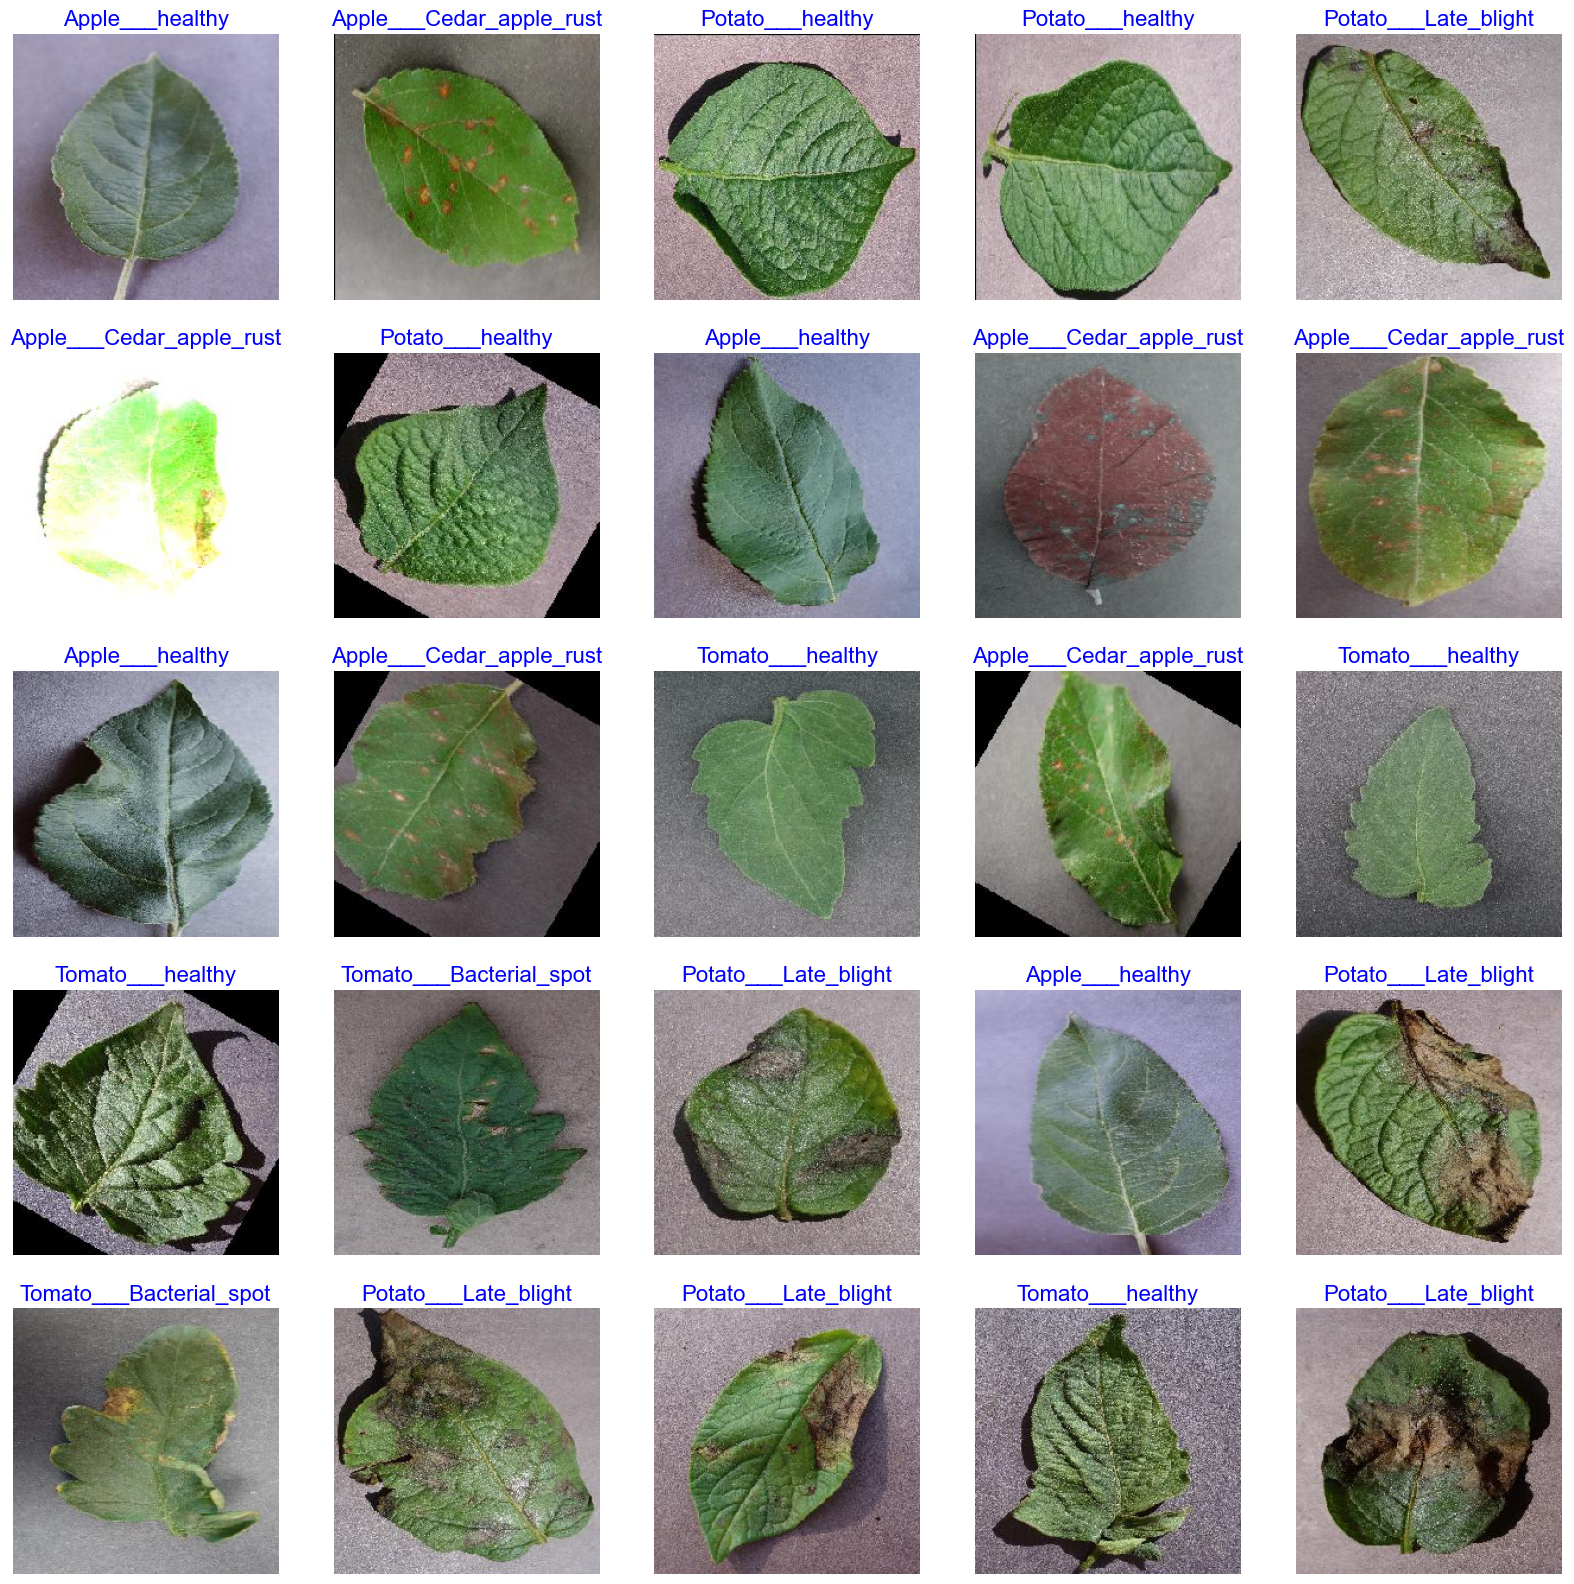

In [165]:
def show_image_samples(gen):
    test_dict=test_gen.class_indices
    classes=list(test_dict.keys())    
    images,labels=next(gen) # get a sample batch from the generator 
    plt.figure(figsize=(20, 20))
    length=len(labels)
    if length<25:   #show maximum of 25 images
        r=length
    else:
        r=25
    for i in range(r):
        plt.subplot(5, 5, i + 1)
        image=images[i]
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color='blue', fontsize=16)
        plt.axis('off')
    plt.show()
    
show_image_samples(train_gen)

MEMBUAT MODEL CNN

In [166]:
base_model=tf.keras.applications.Xception(include_top=False, weights="imagenet",input_tensor=Input(shape=(224,224,3))) 

In [167]:
base_model.trainable = False

In [169]:
model_name='New Plant Diseases Model dengan Xception'
print("Building model with", base_model)
model = tf.keras.Sequential([
        keras.Input(shape=(224, 224, 3)),
        base_model,
        tf.keras.layers.Conv2D(filters=32, padding='same', kernel_size=3, activation='relu', strides=1),
        tf.keras.layers.MaxPool2D(pool_size=2, strides=2),
        tf.keras.layers.Dropout(rate=0.5),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(6, activation='softmax'),
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=.001), loss='categorical_crossentropy', metrics=["accuracy"])
model.summary()

Building model with <Functional name=xception, built=True>


Model: "sequential_29"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ xception (Functional)           │ (None, 7, 7, 2048)     │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_106 (Conv2D)             │ (None, 7, 7, 32)       │       589,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_46 (MaxPooling2D) │ (None, 3, 3, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_30 (Dropout)            │ (None, 3, 3, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_29 (Flatten)            │ (None, 288)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 6)              │         1,734 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,453,070 (81.84 MB)

 Trainable params: 591,590 (2.26 MB)

 Non-trainable params: 20,861,480 (79.58 MB)

In [170]:
epochs =10

history=model.fit(x=train_gen, epochs=epochs, validation_data=valid_gen)

Epoch 1/10


c:\Users\Muhammad fahrian\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


74/74 ━━━━━━━━━━━━━━━━━━━━ 454s 6s/step - accuracy: 0.4782 - loss: 1.4751 - val_accuracy: 0.9542 - val_loss: 0.1605
Epoch 2/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 438s 6s/step - accuracy: 0.9026 - loss: 0.3048 - val_accuracy: 0.9576 - val_loss: 0.1152
Epoch 3/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 438s 6s/step - accuracy: 0.9517 - loss: 0.1501 - val_accuracy: 0.9745 - val_loss: 0.0995
Epoch 4/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 437s 6s/step - accuracy: 0.9664 - loss: 0.1117 - val_accuracy: 0.9677 - val_loss: 0.1039
Epoch 5/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 442s 6s/step - accuracy: 0.9733 - loss: 0.0748 - val_accuracy: 0.9830 - val_loss: 0.0587
Epoch 6/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 434s 6s/step - accuracy: 0.9778 - loss: 0.0757 - val_accuracy: 0.9830 - val_loss: 0.0673
Epoch 7/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 431s 6s/step - accuracy: 0.9775 - loss: 0.0651 - val_accuracy: 0.9813 - val_loss: 0.0694
Epoch 8/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 430s 6s/step - accuracy: 0.9806 - loss: 0.0571 - val_accuracy: 0.9813 - val_loss: 0.